In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import cm
import json
import sys
import os
import glob
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src.feature_selection import RFE
from src import plotting

In [2]:
datadir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/p_feature_selection/rfecv/*'
proc = GatherFeatureDatasets(is_p=True)

In [3]:
# Subset of features I used in RFECV
sr_nonlin_feature_subset = np.array(['amp_ratio_4', 'amp_ratio_5', 'amp_ratio_6', 'amp_ratio_7',
                'amp_1', 'amp_2', 'amp_3', 'amp_4','amp_5', 'signal_variance',
                'signal_dominant_amplitude', 'signal_max_amplitude','signal_dominant_frequency',
                'noise_max_amplitude', 'noise_variance', 
                'source_depth_km', 'source_receiver_distance_logkm',
                'source_receiver_back_azimuth_deg'])

# Get Feature names

I don't think how I set up getting the features names is the best way, but it works for now. Should have saved somewhere or something? No guarantee that the feature order wasn't changed at some point but just going to assume that it wasn't.

In [4]:
# from src.processing import PFeatures
# data_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
# train = pd.read_csv(f'{data_dir}/p.train.csv')
# test = pd.read_csv(f'{data_dir}/p.test.csv')
# _, _, feature_names = proc.process_station_datasets('YNR',
#                                                     train,
#                                                     test,
#                                                     scaler=False,
#                                                     linear_model=False,
#                                                     source_dist_type='dist')
# feature_names_new = PFeatures.make_feature_names(18,
#                                                  linear_model=False)
# assert np.array_equal(feature_names, feature_names_new), 'New method features do not match the original'

In [5]:
# All the feature names
feature_names = proc.get_feature_names(18, 'dist', False)

# Make sure the feature names match the correct columns
sr_feature_names = proc.get_feature_subset_correct_order(feature_names, sr_nonlin_feature_subset)
sr_feature_names

array(['amp_ratio_4', 'amp_ratio_5', 'amp_ratio_6', 'amp_ratio_7',
       'amp_1', 'amp_2', 'amp_3', 'amp_4', 'amp_5',
       'signal_dominant_frequency', 'signal_dominant_amplitude',
       'noise_max_amplitude', 'signal_max_amplitude', 'signal_variance',
       'noise_variance', 'source_depth_km',
       'source_receiver_distance_logkm',
       'source_receiver_back_azimuth_deg'], dtype='<U32')

In [6]:
sr_feature_plot_names = proc.get_feature_plot_names(18, 'dist')[np.where(np.isin(feature_names, sr_feature_names))]
sr_feature_plot_names

array(['ratio 4', 'ratio 5', 'ratio 6', 'ratio 7', 'amp. 1', 'amp. 2',
       'amp. 3', 'amp. 4', 'amp. 5', 'sig. dom. freq.', 'sig. dom. amp.',
       'noise max. amp.', 'sig. max. amp.', 'sig. var.', 'noise var.',
       'depth', 'distance', 'back az.'], dtype='<U15')

# Load the results dictionary json file from RFECV

In [7]:
# Have to do this because the dict with all the results didn't save for P
results_dict = {}
for file in glob.glob(datadir):
    key = os.path.split(file)[-1].split('.')[0]
    with open(file) as fp:
        results = json.load(fp)
    results_dict[key] = results

# Plot the CV results

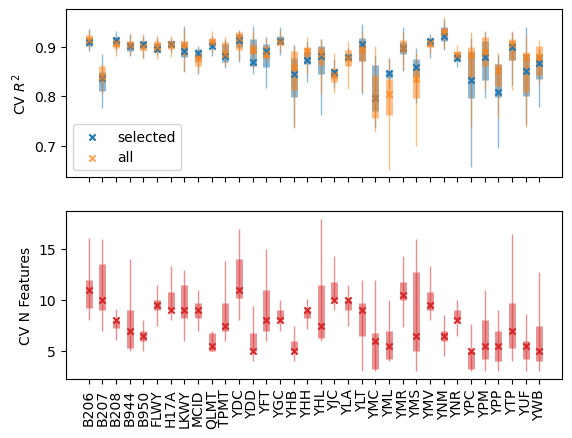

In [8]:
plotting.plot_rfecv_score_summary(results_dict)

# Look into how often features were selected

In [9]:
# Count how many times each feature was selected over RFECV
important_feats_df_dict = {}
for i, key in enumerate(results_dict):
    results = results_dict[key]
    feat_usage_df = RFE.count_feature_usage(np.array(results['optfts_bool']), sr_feature_names)
    important_feats_df_dict[key] = feat_usage_df[['Feature', 'cvcnt']].set_index('Feature')

In [10]:
# Combine the counts from each station
mega_df = None
for key in important_feats_df_dict.keys():
    key_dict = important_feats_df_dict[key].rename(columns={'cvcnt': key})
    if mega_df is None:
        mega_df = key_dict
    else:
        mega_df = mega_df.merge(key_dict, on='Feature')
mega_df = mega_df.loc[sr_feature_names][mega_df.columns.sort_values()]

In [11]:
mega_df

,B206,B207,B208,B944,B950,FLWY,H17A,LKWY,MCID,QLMT,...,YMS,YMV,YNM,YNR,YPC,YPM,YPP,YTP,YUF,YWB
Feature,,,,,,,,,,,,,,,,,,,,,
amp_ratio_4,0,2,3,1,0,0,1,0,2,10,...,0,3,0,2,2,0,2,2,7,1
amp_ratio_5,0,1,1,1,1,0,0,0,1,3,...,0,4,0,0,2,0,0,4,2,0
amp_ratio_6,2,1,1,1,0,0,0,0,2,7,...,1,2,1,0,9,0,1,3,3,0
amp_ratio_7,5,3,1,1,3,0,1,1,0,6,...,0,3,1,2,0,0,0,3,3,0
amp_1,10,10,10,10,10,10,10,9,10,10,...,10,10,8,10,10,10,10,10,10,9
amp_2,4,10,9,4,8,10,9,10,6,10,...,6,9,10,10,2,1,10,9,10,10
amp_3,5,8,9,1,3,2,8,10,5,2,...,4,7,5,9,0,0,10,9,10,2
amp_4,7,5,5,2,1,5,2,7,3,4,...,4,3,10,10,2,0,9,4,10,6
amp_5,4,10,5,1,2,1,5,2,9,5,...,1,2,4,6,0,4,6,5,8,2


In [12]:
# Get the average number of times a feature was selected as important across all stations
mega_df_avg = mega_df.T.mean().round()
mega_df_avg 

Feature
amp_ratio_4                          2.0
amp_ratio_5                          1.0
amp_ratio_6                          2.0
amp_ratio_7                          2.0
amp_1                                9.0
amp_2                                8.0
amp_3                                6.0
amp_4                                5.0
amp_5                                5.0
signal_dominant_frequency            1.0
signal_dominant_amplitude            5.0
noise_max_amplitude                  1.0
signal_max_amplitude                 3.0
signal_variance                      7.0
noise_variance                       1.0
source_depth_km                      7.0
source_receiver_distance_logkm      10.0
source_receiver_back_azimuth_deg     8.0
dtype: float64

In [13]:
# Count how many times a feature was selected as important across all stations
mega_df.T.sum().round()

Feature
amp_ratio_4                          65
amp_ratio_5                          41
amp_ratio_6                          51
amp_ratio_7                          66
amp_1                               322
amp_2                               279
amp_3                               189
amp_4                               173
amp_5                               169
signal_dominant_frequency            21
signal_dominant_amplitude           180
noise_max_amplitude                  30
signal_max_amplitude                 96
signal_variance                     230
noise_variance                       49
source_depth_km                     243
source_receiver_distance_logkm      340
source_receiver_back_azimuth_deg    271
dtype: int64

In [14]:
# Count how many stations a feature was selected >= 5 times
(mega_df >= 5).T.sum()

Feature
amp_ratio_4                          3
amp_ratio_5                          0
amp_ratio_6                          2
amp_ratio_7                          4
amp_1                               33
amp_2                               29
amp_3                               21
amp_4                               17
amp_5                               18
signal_dominant_frequency            1
signal_dominant_amplitude           19
noise_max_amplitude                  0
signal_max_amplitude                 7
signal_variance                     25
noise_variance                       3
source_depth_km                     24
source_receiver_distance_logkm      34
source_receiver_back_azimuth_deg    29
dtype: int64

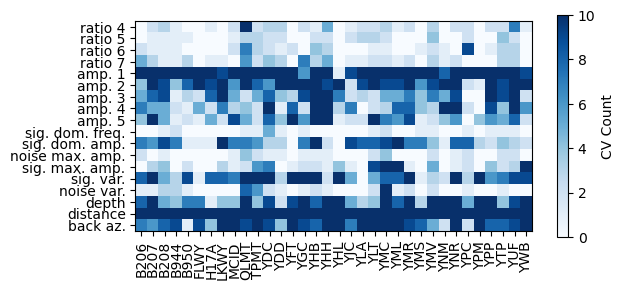

In [15]:
plotting.plot_rfecv_feature_heatmap(mega_df, sr_feature_plot_names)

In [19]:
os.path.dirname(datadir)

'/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/p_feature_selection/rfecv'

In [21]:
mega_df['alt_feat_names'] = sr_feature_plot_names
mega_df.to_csv(os.path.join(os.path.dirname(datadir), 'station_feature_importance.csv'))

Amp 1-5, signal dominant amplitude, signal max amplitude, Signal Variance, Distance, Back Azimuth, Depth, (noise var)?  

Just use Amps 1 & 2

# Correlation matrix of selected features

In [26]:
data_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
train = pd.read_csv(f'{data_dir}/p.train.csv')
test = pd.read_csv(f'{data_dir}/p.test.csv')
X_train, y_train, scaler, feature_names = proc.get_X_y(train, 
                                            scaler=True,
                                            source_dist_type='dist',
                                            linear_model=False)

X shape: (55622, 45), y shape: (55622,)


In [27]:
feature_subset = ['amp_1', 'amp_2', 
'signal_dominant_amplitude','signal_max_amplitude', 'signal_variance',
'noise_variance', 'source_depth_km', 'source_receiver_distance_logkm',
'source_receiver_back_azimuth_deg']
feature_subset_cols = np.where(np.isin(feature_names, feature_subset))[0]


In [28]:
plot_names = proc.get_feature_plot_names(18, 'dist')

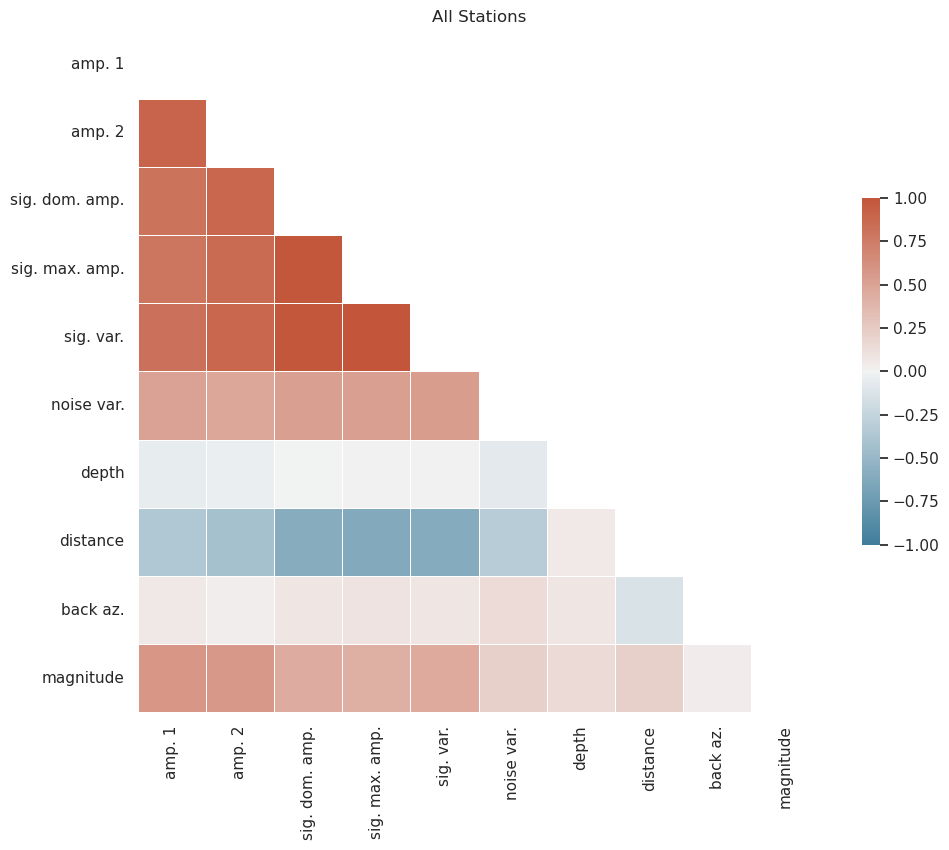

In [29]:
plotting.plot_pairwise_correlations(X_train[:, feature_subset_cols], 
                           y_train, 
                           np.array(plot_names)[feature_subset_cols], 
                           'All Stations',
                           xticklabels=1)